In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d

# ---- Define copper color -----
copper_color = '#B87333'

<h1>Global variables</h1>

In [2]:
# ---- Domain size -----
domain_size = 0.10

# ---- Cable specifications -----
cable_radius = 0.006
cable_diameter = cable_radius * 2
cable_x0 = 0
cable_y0 = 0

# ---- Density in wire -----
I = 20
A = np.pi * (cable_radius**2)
J_sigma = I / A

# ---- Discretization -----
dx = 0.002
dy = 0.002
x_vector = np.arange(-domain_size, domain_size, dx)
y_vector = np.arange(-domain_size, domain_size, dy)
%x_vector += dx/2
y_vector += dy/2
len_x = len(x_vector)
len_y = len(y_vector)

<h1>2D Computation with cartesian Maxwell's equations</h1>

<h2>Domain view</h2>

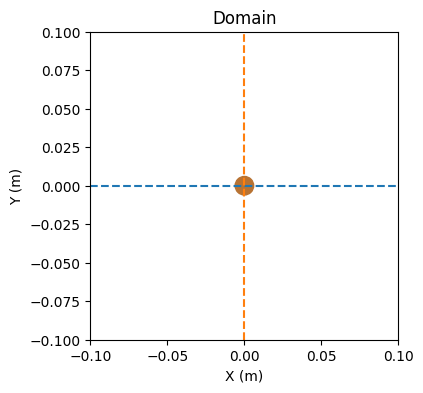

In [3]:
# ---- Plot boundary -----
bound = domain_size

# ---- Plot the domain -----
plt.figure(figsize=(10, 4))
plt.plot([-domain_size, domain_size], [0, 0], '--')  # X-axis
plt.plot([0, 0], [-domain_size, domain_size], '--')  # Y-axis

# ---- Plot the cable -----
circle = plt.Circle((0, 0), cable_radius, color=copper_color, alpha=1)

# ---- Add cable to the plot -----
ax = plt.gca()
ax.add_patch(circle)

# ---- Set limits and labels -----
plt.xlim(-bound, bound)
plt.ylim(-bound, bound)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.title('Domain')
plt.show()

<h2>Density function to compute it at each point in domain</h2>

In [4]:
def density(x, y):
    """
    Calculate the current density at a given point (x, y) based on the distance 
    to the center of the cable.

    This function determines the current density at a specified point in the domain.
    The current density is `J_sigma` if the point is within the cable radius, and 0 
    otherwise.

    Parameters:
    x (float): X-coordinate of the point.
    y (float): Y-coordinate of the point.

    Returns:
    float: The current density at the given point (x, y).

    Notes:
    - The function calculates the distance from the point (x, y) to the cable's center
      located at (cable_x0, cable_y0).
    - If the distance is less than or equal to the cable radius, the function returns 
      the static current density `J_sigma`.
    - If the distance is greater than the cable radius, the function returns 0.
    """
    # ---- Distance to cables centers -----
    distance_to_cable = np.sqrt((x - cable_x0)**2 + (y - cable_y0)**2)

    # ---- Check spot -----
    if distance_to_cable <= cable_radius:
        return J_sigma
    else:
        return 0

<h2>Density visualization</h2>

In [5]:
# ---- Create a grid for J values -----
J = np.zeros((len_y, len_x))

# ---- Calculate J for each point in the grid -----
for i, x in enumerate(y_vector):
    for j, y in enumerate(x_vector):
        J[i, j] = density(x, y)

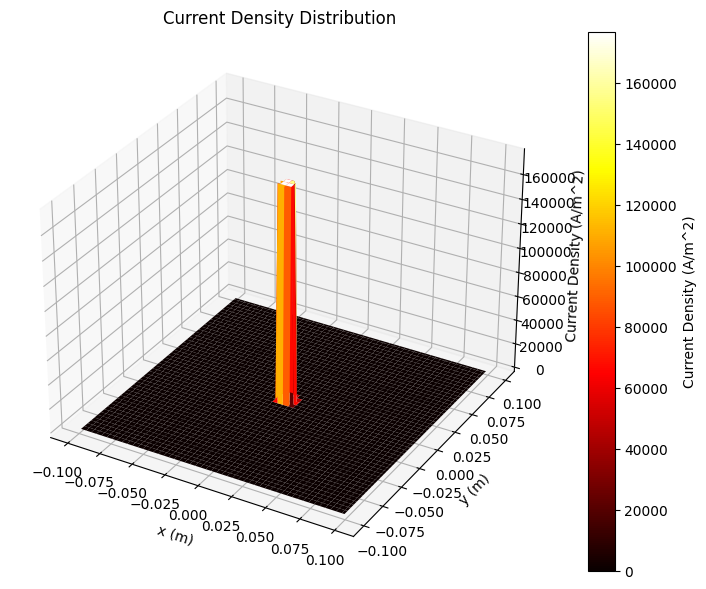

In [6]:
# ---- Create meshgrid for 3D plot -----
X, Y = np.meshgrid(x_vector, y_vector)

# ---- Visualization -----
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, J, cmap='hot', edgecolor='none')
fig.colorbar(surf, ax=ax, label='Current Density (A/m^2)')
ax.set_title('Current Density Distribution')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('Current Density (A/m^2)')

plt.show()

<h2>Assembly to solve $\quad \rightarrow \quad A \times H = J$</h2>
$A_{H_y} \times H_y\ +\ A_{H_x} \times H_x\ =\ J$

<h3>Initialization</h3>

In [7]:
inv_dx = 1 / dx
inv_dy = 1 / dy
len_H = len_x * len_y
Hx_vector = np.zeros(len_H)
Hy_vector = np.zeros(len_H)
H_vector = np.zeros(2*len_H)
Assemble_Hx = np.diag([-1.] * len_H)
Assemble_Hy = np.diag([-1.] * len_H)

<h3>Assembly $J$</h3>

In [8]:
# ---- Transform J to vector row by row -----
J_vector = J.flatten()  # J.flatten() transforms matrix J into vector (row by row)

<h3>Assembly Matrix $A\ =\ (A_{H_y}\ |\ -A_{H_x})$</h3>

In [9]:
# ---- Assembly matrix A_Hy -----
for j in range(len_y):
    for i in range(len_x-1):
        Assemble_Hy[j*len_x+i, j*len_x+i+1] = 1    
Assemble_Hy *= inv_dx

# ---- Assembly matrix A_Hx -----
for j in range(len_y-1):
    for i in range(len_x):
        Assemble_Hx[j*len_x+i, (j+1)*len_x+i] = 1         
Assemble_Hx *= -inv_dy

# ---- Concatenate A -----
Assemble_H = np.hstack((Assemble_Hy, Assemble_Hx))

<h3>Singular Value Decomposition (SVD) to solve equation</h3>

In [10]:
# ---- SVD decomposition on dense matrix -----
U, S, VT = np.linalg.svd(Assemble_H, full_matrices=False)

In [11]:
# ---- Pseudo-inverse computation -----
S_inv = np.diag(1 / S)

In [12]:
Assemble_H_pseudo_inv = VT.T @ S_inv @ U.T  # Complete pseudo-inverse computation

In [13]:
# ---- Solve equation Ah + j = 0 => h = -A_pseudo_inv @ j -----
H_vector = Assemble_H_pseudo_inv @ J_vector

In [14]:
# ---- Hx and Hy extraction -----
Hy_vector = H_vector[0 : len_H]
Hx_vector = H_vector[len_H :]

# ---- Reshape Hx and Hy in matrix -----
Hx = Hx_vector.reshape((len_x, len_y))
Hy = Hy_vector.reshape((len_x, len_y))

<h3>$H_x$ and $H_y$ computations</h3>

In [15]:
X, Y = np.meshgrid(x_vector, y_vector)

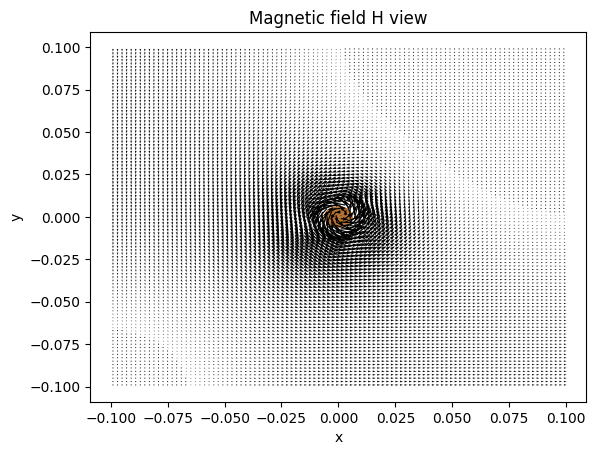

In [16]:
# ---- Create figure -----
plt.figure()

# ---- Plot the cable -----
circle = plt.Circle((0, 0), cable_radius, color=copper_color, alpha=1)

# ---- Add cable to the plot -----
ax = plt.gca()
ax.add_patch(circle)

# ---- Plot magnetic field -----
plt.quiver(X, Y, Hx, Hy)

# ---- Set labels -----
plt.title('Magnetic field H view')
plt.xlabel('x')
plt.ylabel('y')

# ---- figure display -----
plt.show()

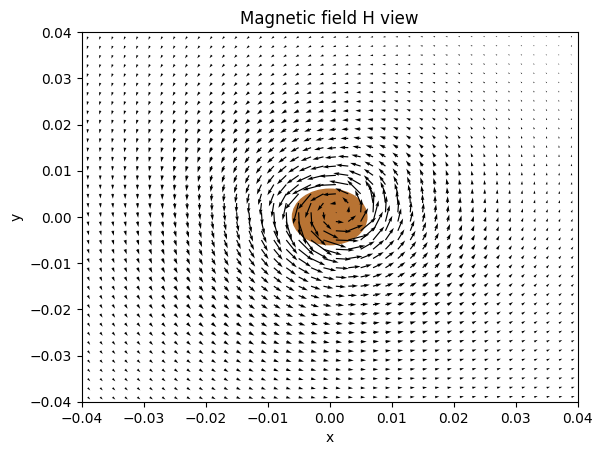

In [17]:
bound = 0.04

# ---- Create figure -----
plt.figure()

# ---- Plot the cable -----
circle = plt.Circle((0, 0), cable_radius, color=copper_color, alpha=1)

# ---- Add cable to the plot -----
ax = plt.gca()
ax.add_patch(circle)

# ---- Plot magnetic field -----
plt.quiver(X, Y, Hx, Hy)

# ---- Set limits and labels -----
plt.title('Magnetic field H view')
plt.xlabel('x')
plt.ylabel('y')

plt.xlim([-bound, bound])
plt.ylim([-bound, bound])

# ---- Figure display -----
plt.show()

In [18]:
def interp_f(neighbors_matrix):
    """
    Estimates the interpolated value of a 2D scalar field at the center of a unit square
    using the values at its top-left corner and immediate neighbors.

    Parameters:
    -----------
    neighbors_matrix : numpy.ndarray or array-like of shape (2, 2)
        A 2x2 matrix containing the scalar values at four neighboring points:
        [ [f(i, j),     f(i, j+1)],
          [f(i+1, j),   f(i+1, j+1)] ]
        where (i, j) refers to the top-left corner of the cell.

    Returns:
    --------
    float
        Interpolated value at the center of the square formed by the four points.

    Notes:
    ------
    This function performs bilinear interpolation and computes the value at the center
    of the 2x2 neighborhood (i+0.5, j+0.5). The computation uses first-order differences
    in x and y directions and a mixed difference term to approximate the center value.
    """
    Dfx = neighbors_matrix[1, 0] - neighbors_matrix[0, 0]
    Dfy = neighbors_matrix[0, 1] - neighbors_matrix[0, 0]
    Dfxy = neighbors_matrix[0, 0] + neighbors_matrix[1, 1] - neighbors_matrix[1, 0] - neighbors_matrix[0,1]
    f = (0.5 * Dfx) + (0.5 * Dfy) + (0.25 * Dfxy) + neighbors_matrix[0, 0]
    return f

In [19]:
k = int(len_x / 2)
x = x_vector[k-1:]
y = y_vector[k-1:]
n = len(x)
Hy_interpolated_x = np.zeros(n)
Hx_interpolated_x = np.zeros(n)

Hy_interpolated_y = np.zeros(n)
Hx_interpolated_y = np.zeros(n)
# ---- Bilinear interpolation -----
Hy_x = Hy[k-1 :, k-1 : k+1]
Hx_x = Hx[k-1 :, k-1 : k+1]

Hy_y = Hy[k-1 : k+1, k-1 :]
Hx_y = Hx[k-1 : k+1, k-1 :]

for i in range(n-1):
    Hy_interpolated_x[i] = interp_f(Hy_x[i : i+2, :])
    Hx_interpolated_x[i] = interp_f(Hx_x[i : i+2, :])

    Hy_interpolated_y[i] = interp_f(Hy_y[:, i : i+2])
    Hx_interpolated_y[i] = interp_f(Hx_y[:, i : i+2])

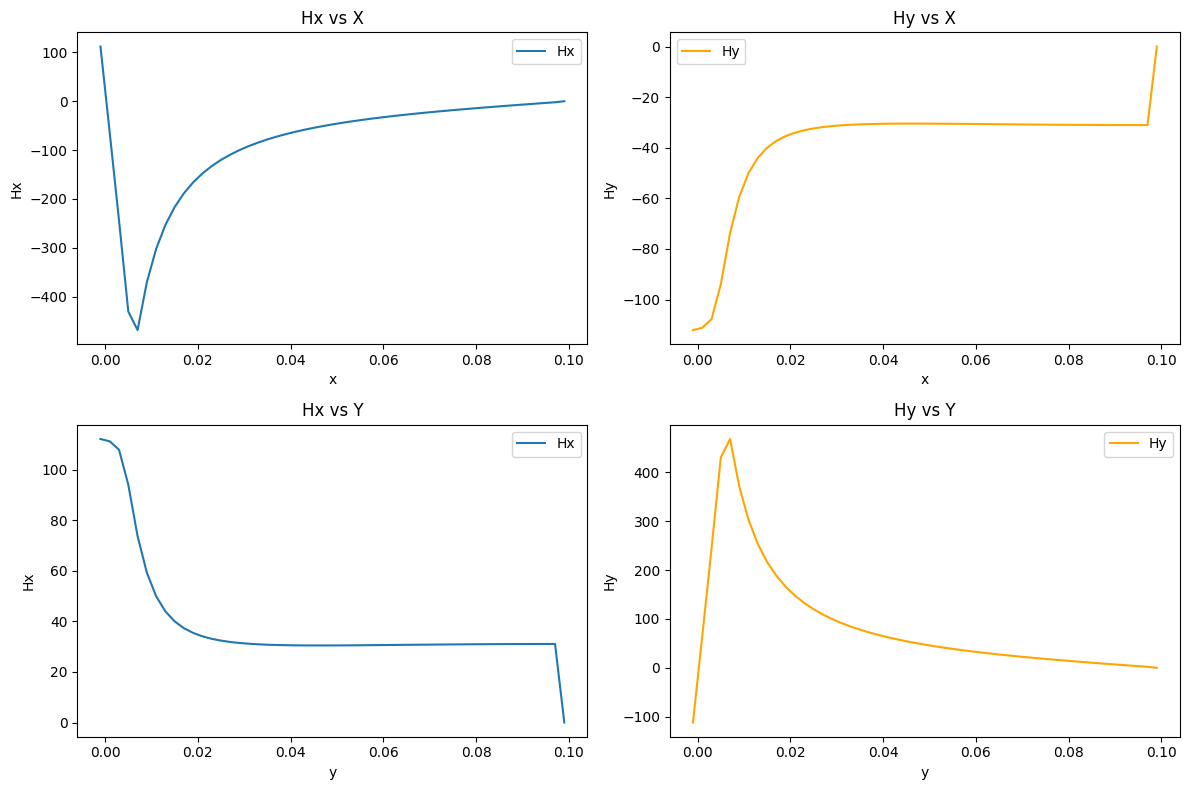

In [20]:
# ---- Subgraph creation -----
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# ---- Plot Hx as a function of x_vector -----
axs[0, 0].plot(x, Hx_interpolated_x, label='Hx')
axs[0, 0].set_title('Hx vs X')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('Hx')
axs[0, 0].legend()

# ---- Plot Hy as a function of x_vector -----
axs[0, 1].plot(x, Hy_interpolated_x, label='Hy', color='orange')
axs[0, 1].set_title('Hy vs X')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('Hy')
axs[0, 1].legend()

# ---- Plot Hx as a function of y_vector -----
axs[1, 0].plot(y, Hx_interpolated_y, label='Hx')
axs[1, 0].set_title('Hx vs Y')
axs[1, 0].set_xlabel('y')
axs[1, 0].set_ylabel('Hx')
axs[1, 0].legend()

# ---- Plot Hy as a function of y_vector -----
axs[1, 1].plot(y, Hy_interpolated_y, label='Hy', color='orange')
axs[1, 1].set_title('Hy vs Y')
axs[1, 1].set_xlabel('y')
axs[1, 1].set_ylabel('Hy')
axs[1, 1].legend()

# ---- Figure display -----
plt.tight_layout()     # Adjust subgraph spacing 

plt.show()

In [21]:
Hy_interpolated_x = np.zeros(len_x)
Hx_interpolated_x = np.zeros(len_x)

Hy_interpolated_y = np.zeros(len_x)
Hx_interpolated_y = np.zeros(len_x)

# ---- Bilinear interpolation -----
Hy_x = Hy[: , k-1 : k+1]
Hx_x = Hx[: , k-1 : k+1]

Hy_y = Hy[k-1 : k+1, :]
Hx_y = Hx[k-1 : k+1, :]

for i in range(len_x-1):
    Hy_interpolated_x[i+1] = interp_f(Hy_x[i : i+2, :])
    Hx_interpolated_x[i+1] = interp_f(Hx_x[i : i+2, :])

    Hy_interpolated_y[i+1] = interp_f(Hy_y[:, i : i+2])
    Hx_interpolated_y[i+1] = interp_f(Hx_y[:, i : i+2])

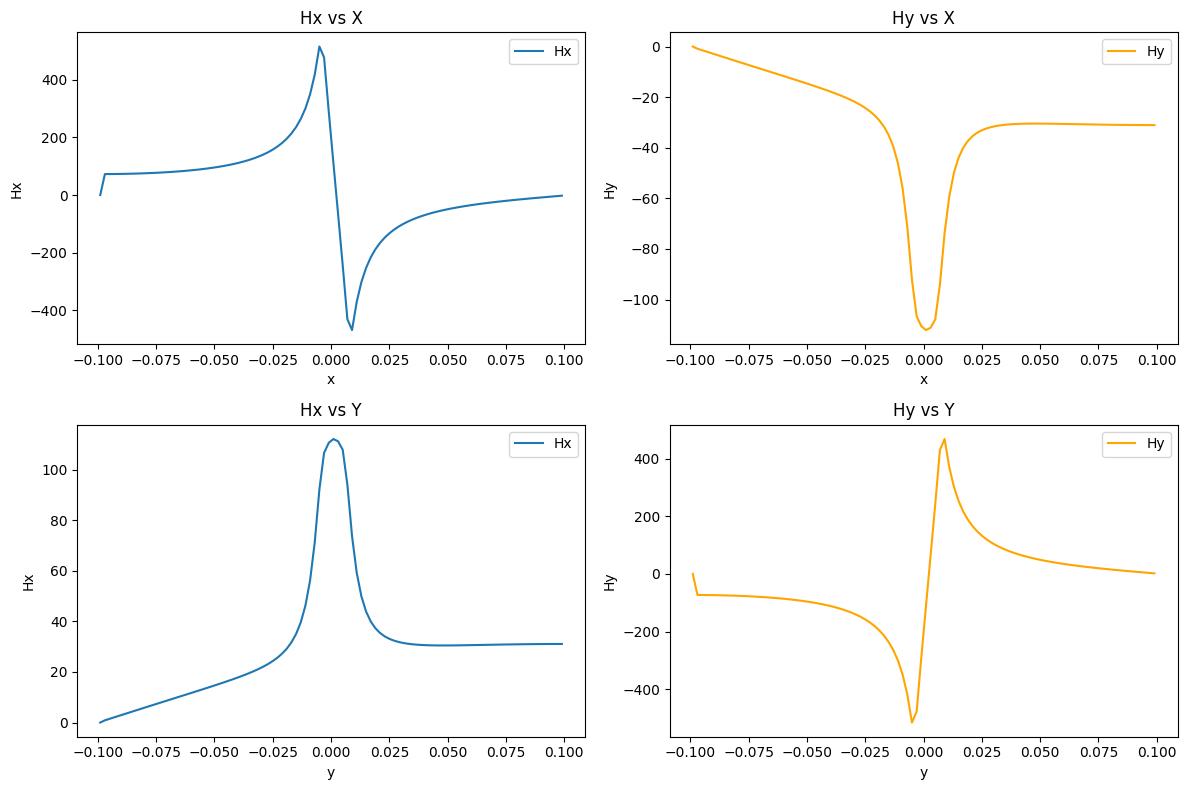

In [22]:
# ---- Subgraph creation -----
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# ---- Plot Hx as a function of x_vector -----
axs[0, 0].plot(x_vector, Hx_interpolated_x, label='Hx')
axs[0, 0].set_title('Hx vs X')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('Hx')
axs[0, 0].legend()

# ---- Plot Hy as a function of x_vector -----
axs[0, 1].plot(x_vector, Hy_interpolated_x, label='Hy', color='orange')
axs[0, 1].set_title('Hy vs X')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('Hy')
axs[0, 1].legend()

# ---- Plot Hx as a function of y_vector -----
axs[1, 0].plot(y_vector, Hx_interpolated_y, label='Hx')
axs[1, 0].set_title('Hx vs Y')
axs[1, 0].set_xlabel('y')
axs[1, 0].set_ylabel('Hx')
axs[1, 0].legend()

# ---- Plot Hy as a function of y_vector -----
axs[1, 1].plot(y_vector, Hy_interpolated_y, label='Hy', color='orange')
axs[1, 1].set_title('Hy vs Y')
axs[1, 1].set_xlabel('y')
axs[1, 1].set_ylabel('Hy')
axs[1, 1].legend()

# ---- Figure display -----
plt.tight_layout()     # Adjust subgraph spacing 

plt.show()

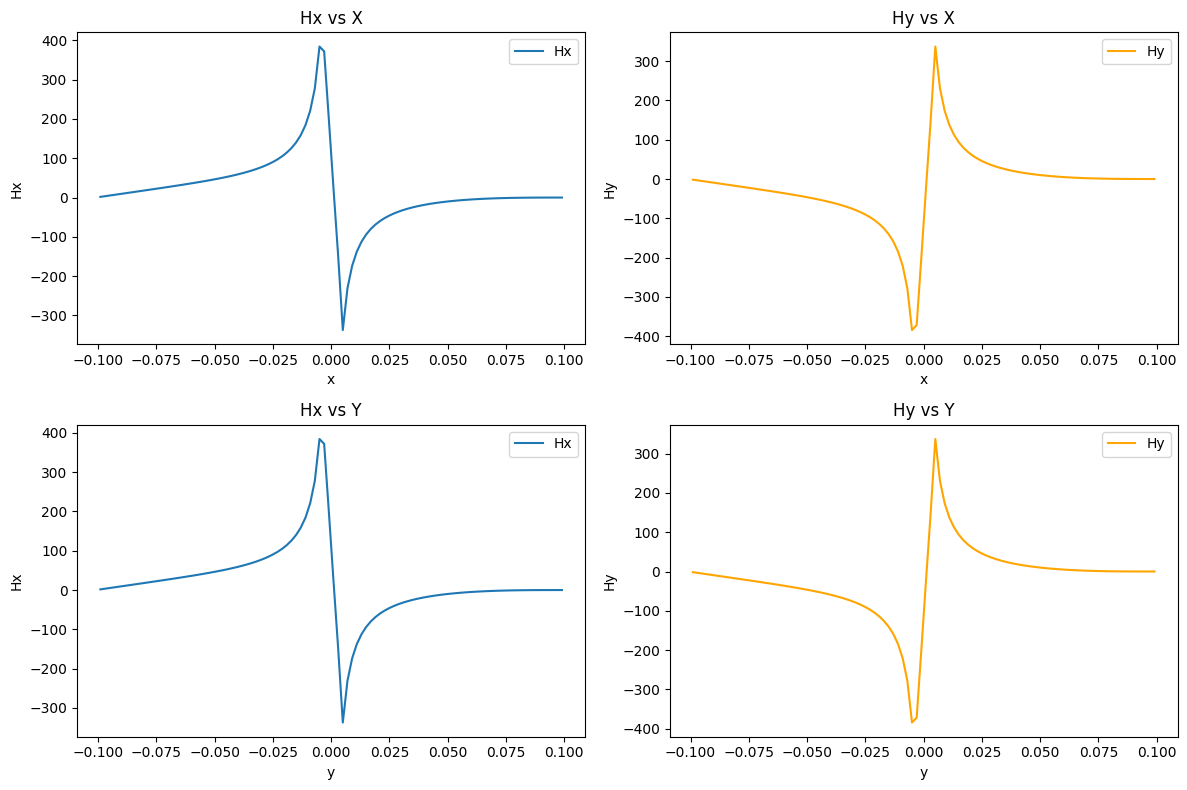

In [23]:
Hx_diag = np.diag(Hx)
Hy_diag = np.diag(Hy)

# ---- Subgraph creation -----
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# ---- Plot Hx as a function of x_vector -----
axs[0, 0].plot(x_vector, Hx_diag, label='Hx')
axs[0, 0].set_title('Hx vs X')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('Hx')
axs[0, 0].legend()

# ---- Plot Hy as a function of x_vector -----
axs[0, 1].plot(x_vector, Hy_diag, label='Hy', color='orange')
axs[0, 1].set_title('Hy vs X')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('Hy')
axs[0, 1].legend()

# ---- Plot Hx as a function of y_vector -----
axs[1, 0].plot(y_vector, Hx_diag, label='Hx')
axs[1, 0].set_title('Hx vs Y')
axs[1, 0].set_xlabel('y')
axs[1, 0].set_ylabel('Hx')
axs[1, 0].legend()

# ---- Plot Hy as a function of y_vector -----
axs[1, 1].plot(y_vector, Hy_diag, label='Hy', color='orange')
axs[1, 1].set_title('Hy vs Y')
axs[1, 1].set_xlabel('y')
axs[1, 1].set_ylabel('Hy')
axs[1, 1].legend()

# ---- Figure display -----
plt.tight_layout()     # Adjust subgraph spacing 

plt.show()

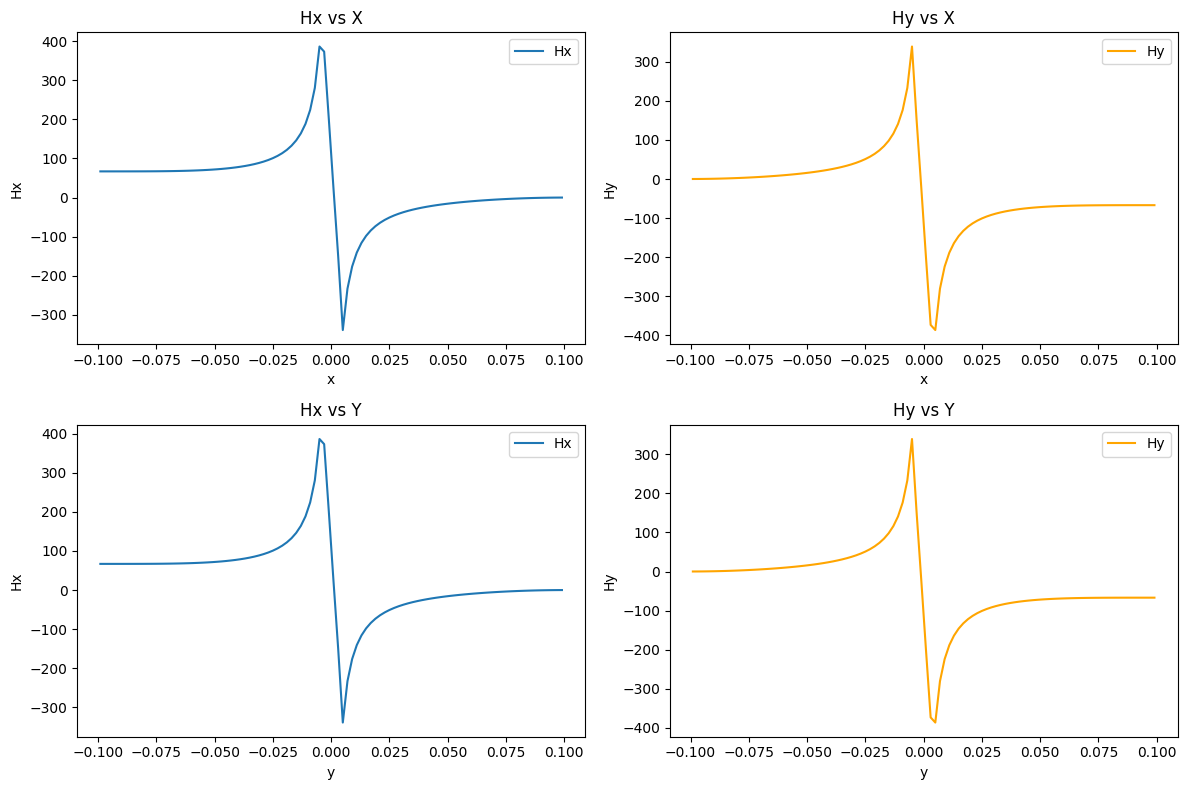

In [24]:
# ---- Extraire la diagonale inverse (anti-diagonale) ----
Hx_diag = np.fliplr(Hx).diagonal()  
Hy_diag = np.fliplr(Hy).diagonal()

# ---- Subgraph creation -----
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# ---- Plot Hx as a function of x_vector -----
axs[0, 0].plot(x_vector, Hx_diag, label='Hx')
axs[0, 0].set_title('Hx vs X')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('Hx')
axs[0, 0].legend()

# ---- Plot Hy as a function of x_vector -----
axs[0, 1].plot(x_vector, Hy_diag, label='Hy', color='orange')
axs[0, 1].set_title('Hy vs X')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('Hy')
axs[0, 1].legend()

# ---- Plot Hx as a function of y_vector -----
axs[1, 0].plot(y_vector, Hx_diag, label='Hx')
axs[1, 0].set_title('Hx vs Y')
axs[1, 0].set_xlabel('y')
axs[1, 0].set_ylabel('Hx')
axs[1, 0].legend()

# ---- Plot Hy as a function of y_vector -----
axs[1, 1].plot(y_vector, Hy_diag, label='Hy', color='orange')
axs[1, 1].set_title('Hy vs Y')
axs[1, 1].set_xlabel('y')
axs[1, 1].set_ylabel('Hy')
axs[1, 1].legend()

# ---- Figure display -----
plt.tight_layout()     # Adjust subgraph spacing 

plt.show()

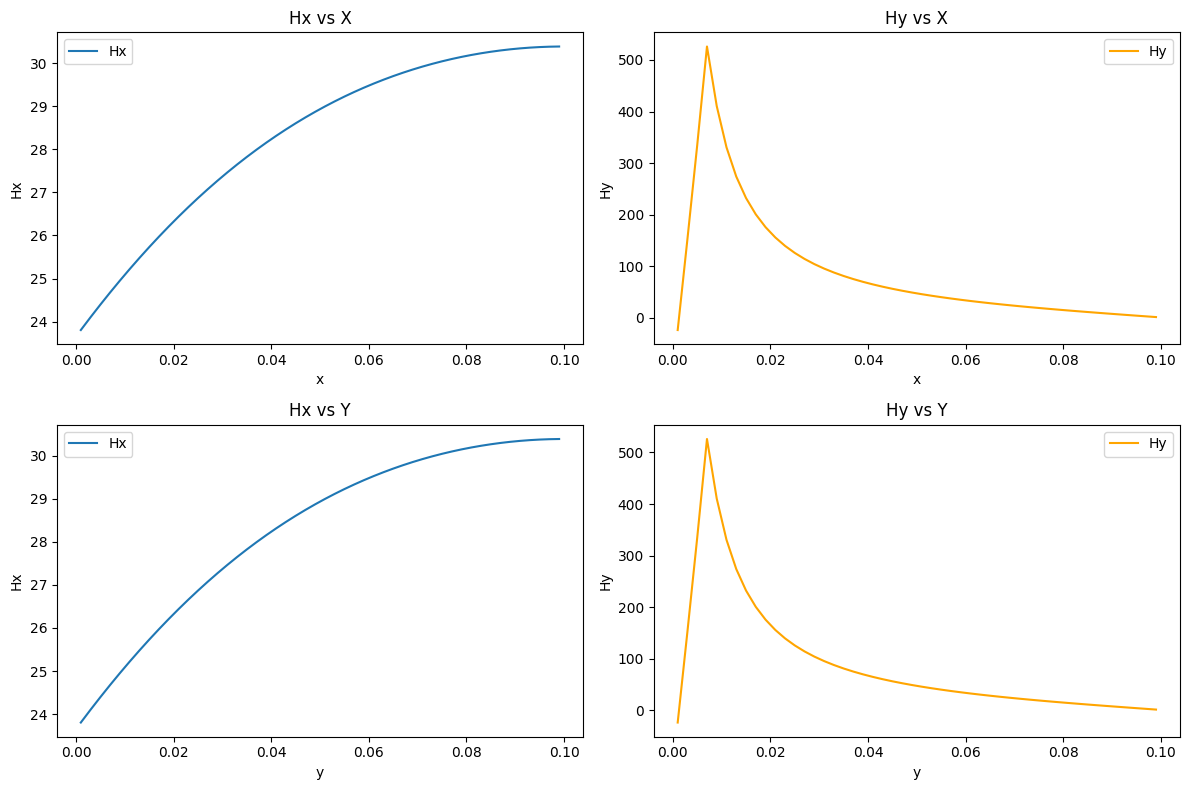

In [25]:
'!!!!!!!!!  ---- Only for dr = dx = dy = 0.002 -----  !!!!!!!!!'

k = 0       # choose k in [-49, 49]
l = 0       # Choose l in [-49, 49]

# ---- Subgraph creation -----
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# ---- Plot Hx as a function of x_vector -----
axs[0, 0].plot(x_vector[50:], Hx[50+k, 50:], label='Hx')
axs[0, 0].set_title('Hx vs X')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('Hx')
axs[0, 0].legend()

# ---- Plot Hy as a function of x_vector -----
axs[0, 1].plot(x_vector[50:], Hy[50+k, 50:], label='Hy', color='orange')
axs[0, 1].set_title('Hy vs X')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('Hy')
axs[0, 1].legend()

# ---- Plot Hx as a function of y_vector -----
axs[1, 0].plot(y_vector[50:], Hx[50+l, 50:], label='Hx')
axs[1, 0].set_title('Hx vs Y')
axs[1, 0].set_xlabel('y')
axs[1, 0].set_ylabel('Hx')
axs[1, 0].legend()

# ---- Plot Hy as a function of y_vector -----
axs[1, 1].plot(y_vector[50:], Hy[50+l, 50:], label='Hy', color='orange')
axs[1, 1].set_title('Hy vs Y')
axs[1, 1].set_xlabel('y')
axs[1, 1].set_ylabel('Hy')
axs[1, 1].legend()

# ---- Figure display -----
plt.tight_layout()     # Adjust subgraph spacing 
plt.show()

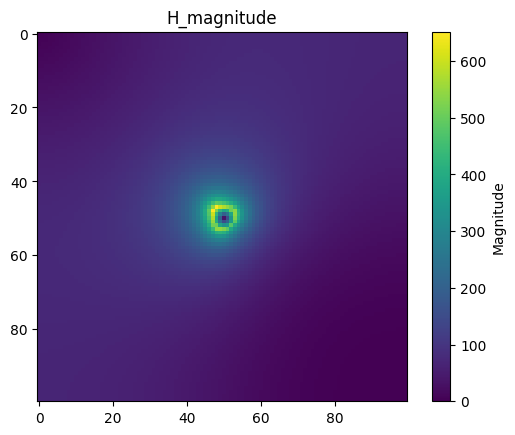

In [26]:
# Compute H_magnitude
H_magnitude = np.sqrt(Hx**2 + Hy**2)

# Show H_magnitude
plt.imshow(H_magnitude, cmap='viridis')
plt.colorbar(label='Magnitude')
plt.title('H_magnitude')
plt.show()